# JAX

## Introduction

### Installation

You should have installed `jax`. If not, please now do so by executing the command:

```pip install jaxlib jax```

or use Google Colab.

### Why and when should you use JAX?

It is good to use JAX if your project requires any of 
- Python is your primary languqge;
- Just-In-Time (JIT) compilation for fast computation;
- Automatic differentiation;
- Vectorization;
- Multiple GPU/TPU acceleration, etc.

### Easy to use

JAX is like a sum of multiple friendly libraries in Python. That is, JAX = numpy + scipy + essential functionalities (e.g., auto-diff, JIT, and parallelization). If you use `numpy` then you should have no problem to use `jax`.

<center>

|NumPy|JAX|
|--|--|
|`import numpy as np`|`import jax.numpy as jnp`|
|`np.array()`|`jnp.array()`|
|`np.zeros()`|`jnp.zeros()`|
|`np.ones()`|`jnp.ones()`|
|`np.eye()`|`jnp.eye()`|
|`np.sin()`|`jnp.sin()`|
|`np.linalg`|`jnp.linalg`|

</center>

### Galleries: Some Motivating Examples

#### Auto-Differentiation

In [1]:
import jax
import jax.numpy as jnp

def f(x):
    return x * jnp.sin(x) + jnp.cos(x)

grad_of_f = jax.grad(f) # jax.grad returns a function
grad_of_f(1.)

Array(0.5403023, dtype=float32, weak_type=True)

You say you can compute the gradient by hand? How about something deep ...

In [2]:
def something_deep(x):
    for i in range(100):
        x = f(x)
    return x

grad_of_deep = jax.grad(something_deep)
grad_of_deep(1.)

Array(0., dtype=float32, weak_type=True)

#### JIT Speed Up

In [3]:
import numpy as np

def softmax_np(x):
    """
    Softmax in NumPy
    """
    z = np.exp(x)
    return z / np.sum(z, axis=0)

@jax.jit
def softmax_jax(x):
    """
    Softmax in JAX
    """
    z = jnp.exp(x)
    return z / jnp.sum(z, axis=0)

In [4]:
x = np.ones((10, 1000))
%timeit softmax_np(x)

21.1 μs ± 223 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [5]:
x = jnp.ones((10, 1000))
%timeit softmax_jax(x).block_until_ready()

17.1 μs ± 31.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Initialization

In [57]:
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

JAX by default uses `float32` for the best compatibility with GPUs. You need to manually do the following to enable `float64` globally.

In [6]:
jax.config.update('jax_enable_x64', True)

In [79]:
jax.devices()

[CpuDevice(id=0)]

## JIT in JAX

Suppose that we have a function that is giga-computational demanding.

```python
def expensive_func(x):
    # a bunch of giga-heavy computations
    # Python is slow, and NumPy too
    return ...
```

JAX can make the function above faster by compiling it into machine codes by using the JIT compilation. We trigger the **compilation** by calling `jax.jit`.

```python
import jax
jitted_func = jax.jit(expensive_func)
```

Note the return `jitted_func` is a function that has exactly the same signature as `expensive_func`. It is equivalent to put a decorator over the function definition.

```python
@jax.jit
def expensive_func(x):
    ...
    return ...
```

We begin with a simple example.

In [7]:
def func_np(x):
    return np.diff(np.diff(np.diff(np.diff(np.diff(x)))))

@jax.jit
def func_jax(x):
    return jnp.diff(jnp.diff(jnp.diff(jnp.diff(jnp.diff(x)))))

x = np.random.randn(100_000)
xj = jnp.asarray(x)

In [8]:
%timeit func_np(x)

71.5 μs ± 2.49 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
# Trigger JIT
# func_jax(xj)

In [11]:
%timeit func_jax(xj).block_until_ready()

42.8 μs ± 594 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Around 2 times faster. NumPy uses OpenBLAS/MKL/BLIS... as backend. Why is it still slow? A more illustrative example which shows that the overhead of NumPy is problematic:

In [12]:
A, B = np.eye(50), np.eye(50)

def func_np(x):
    for i in range(100):
        x = B @ x + np.linalg.solve(A, x) + np.linalg.norm(x)
    return x

In [13]:
# JAX version of the code above
Aj, Bj = jnp.eye(50), jnp.eye(50)

@jax.jit
def func_jax(x):
    def scan_body(carry, _):
        x = carry
        return Bj @ x + jnp.linalg.solve(Aj, x) + jnp.linalg.norm(x), _
    return jax.lax.scan(scan_body, x, jnp.arange(100))[-1]

In [14]:
%timeit func_np(np.ones((50, )))

1.59 ms ± 40.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
# Trigger JIT
# func_jax(jnp.ones((50, )))

%timeit func_jax(jnp.ones((50, ))).block_until_ready()

23 μs ± 334 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### What happened inside JIT?

1. When Python executes `func_jax` for the first time, the function `jax.jit` traces and traverses all the operations inside the function `func_jax`.
2. Then JIT compiles these operations into the accelerated linear algebra (XLA) codes. Imagine this as that of compiling C codes to an executable file. No numerical operations are done!
3. Then, by the next time you call the jitted `func_jax`, Python will execute the compiled XLA codes to carry out the numerical computations.
4. After the numerical computations are done in the machine level, the results are sent back to Python.

JAX basically uses Python as a **metaprogramming language** that specifies how to build an XLA program (quote by [Patrck Kidger](https://kidger.site/thoughts/jax-vs-julia/))

### When and Where to JIT?

Usually, we JIT
- the part that has the largest scope, so that the compiler can understand your program better,
- or the function(s) that are called repetitively, for instance, the objective function in optimization:
```python
@jax.jit
def objective_func(params):
    ...
    return ...
```

Remember, when we write the JAX code, we are describing a computation flow.

### Will these work?

Note that the following example do not work. Guess why.

In [17]:
@jax.jit
def my_func(x):
    return np.exp(x)

my_func(jnp.ones((2, )))

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[2]
The error occurred while tracing the function my_func at /var/folders/n5/bkphn15s0kzc1lsr8x64v8y00000gn/T/ipykernel_1159/153899635.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

Below does not work in some early JAX versions; now, they do!

In [19]:
@jax.jit
def my_func(x):
    return x + np.array([1., 2.])

print(my_func(jnp.ones((2, ))))
print(my_func(np.ones(2, )))

[2. 3.]
[2. 3.]


In [20]:
class MyClass:

    def __init__(self):
        self.y = jnp.array(1.)

    @jax.jit
    def my_method(self, x):
        return x + self.y

Notice that the following does not work.

In [21]:
obj = MyClass()
obj.my_method(jnp.array(2.))

TypeError: Error interpreting argument to <function MyClass.my_method at 0x11b1e1300> as an abstract array. The problematic value is of type <class '__main__.MyClass'> and was passed to the function at path self.
This typically means that a jit-wrapped function was called with a non-array argument, and this argument was not marked as static using the static_argnums or static_argnames parameters of jax.jit.

We can force it to work by adding a `static argnums` option. This assumes that `self` is static, i.e., immutable.

In [22]:
from functools import partial

In [23]:
class MyClass:
    
    def __init__(self):
        self.y = jnp.array(1.)

    @partial(jax.jit, static_argnums=(0, ))
    def my_method(self, x):
        return x + self.y

In [24]:
obj = MyClass()
obj.my_method(jnp.array(2.))

Array(3., dtype=float64, weak_type=True)

Similarly, this will not (immediately) work either:

```python
@jax.jit
def f(x, g: Callable):
    return x + g(x)
```

We have to make it clear that the argument `g` is static:

```python
@partial(jax.jit, static_argnums=(1, ))
def f(x, g: Callable):
    return x + g(x)
```

A more concise way is to put `g` in an outer scope.

```python
g = ... # definition of g from outer scope

@jax.jit
def f(x):
    return x + g(x)
```

Note that whenever the static argument changes, it will trigger the JIT compilation again to create another XLA code. JAX accepts immutable objects, while Python Class is mutable. For instance,

In [25]:
x = jnp.ones((2, ))
x[0] = 1. # This does not work.

TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

Well, so far, doesn't JAX suck if we cannot even assign or update values to variables? No, this in my opinion a feature not a problem. Immutable objects are best for computations. For projects that need mutable objects, we can rewrite then into that of based on immutable ones.

## Randomness

### Generating Random Numbers

Generating random numbers in JAX needs the programmer to be conscious, not drunk. This is going to look painful in the beginning. But in the end we will see this is super helpful in controlling the randomness flow. 

Think about how to generate random samples in NumPy, for example, 

```python
np.random.seed(100)
samples1 = np.random.randn(5)
samples2 = np.random.uniform(5)
samples3 = np.random.gamma(5)
```

The results are reproducible under a fixed random seed.

Then analogously, can we do the following?

```python
jnp.random.seed(100)
```

No, we have to manually play with random keys by yourself, like in C, C++, or Rust.

In [27]:
# The equivalence to the NumPy code

key = jax.random.PRNGKey(100)
samples1 = jax.random.normal(key, shape=(5, ))

key, _ = jax.random.split(key)
samples2 = jax.random.uniform(key, shape=(5, ))

key, _ = jax.random.split(key)
samples3 = jax.random.gamma(key, shape=(5, ), a=1.)

We may think explicitly splitting random keys is a fuss/verbose, but this is standard for asynchronous/parallel/vectorizable programs. Recall the NumPy version:
```python
np.random.seed(100)
samples1 = np.random.randn(5)
samples2 = np.random.uniform(5)
samples3 = np.random.gamma(5)
```
Why are the results reproducible? Because, (1) the random seed is fixed, and (2) the order of execution is fixed. If `samples1`, `samples2`, and `samples3` are executed in parallel, can you guarantee the results are the same? No, because you will not know the order of execution. This essentially introduces another randomness (at hardware level) that is hard to control.

In [29]:
key = jax.random.PRNGKey(100)
print(key)

# The randomness under this splitted key is independent of the previous key.
key, subkey = jax.random.split(key)
print(key, subkey)

key, subkey = jax.random.split(key)
print(key, subkey)

keys = jax.random.split(key, num=5)
print(keys)

[  0 100]
[ 701046466 2104227382] [2213033797 2583756506]
[3549270403 1145628597] [1315821631 2840677502]
[[2733948186  829389578]
 [2279201908 4116190116]
 [1481730141 3233576484]
 [1130548228  472880600]
 [4224117979 1514228929]]


In practice, you can just ignore `subkey` which is used to track randomness:

```python
key, _ = jax.random.split(key)
```

Imagine that we have an algorithm and we would like to test it on a synthetic model for 100 **independent** Monte Carlo runs then average the results.

```python
# Example code 
num_mcs = 100
for i in range(num_mcs):
    np.random.seed(i)
    data = generate_data()
    result = my_algorithm(data)
```

The implementation above is a common mistake, as seeds 1, 2, ..., 100 are not independent. How to make the randomness in the loop independent to each other? I actually don't know how to do so in NumPy.

In JAX, it is convenient:

```python
num_mcs = 100
key = jax.random.PRNGKey(1)
for i in range(num_mcs):
    key, _ = jax.random.split(key)
    data = generate_data
    result = my_algorithm(data)
```

Let's do a simple exercise: Generate two random positive definite matrices of size 6, then add them. The NumPy-style implementation is as follows:

In [31]:
np.random.seed(999)

rand = np.random.randn(6)
psd_matrix_1 = np.outer(rand, rand) + np.eye(6)

rand = np.random.randn(6)
psd_matrix_2 = np.outer(rand, rand) + np.eye(6)

print(np.linalg.eigh(psd_matrix_1 + psd_matrix_2)[0])

[ 2.          2.          2.          2.          4.05034118 13.36009279]


Then the JAX version of the code is as follows.

In [37]:
key = jax.random.PRNGKey(100)
rand = jax.random.normal(key, shape=(6, ))
psd_matrix_1 = jnp.outer(rand, rand) + jnp.eye(6)

key, _ = jax.random.split(key)
rand = jax.random.normal(key, shape=(6, ))
psd_matrix_2 = jnp.outer(rand, rand) + jnp.eye(6)

print(jnp.linalg.eigh(psd_matrix_1 + psd_matrix_2)[0])

[2.         2.         2.         2.         4.43398354 8.80012971]


## Vectorization

Vectorization is one of the most helpful feature of JAX for economic modeling. The vectorization here is not the same as parallelization.

Let's begin with some example. Suppose that we have two arrays `a` and `b` of shapes `(10, 5, 3, 6)` and `(10, 3, 7, 6)`, respectively. Then how do we do `a @ b` in the way that the multiplication applies to `(5, 3) ⨉ (3, 7)` while taking other dimesions as the broadcasting dimension? Eventually, we desire an array of shape `(10, 5, 7, 6)`. How do we do it in NumPy or Matlab? (Recall `einsum`.)

In [38]:
# Answer here.

Now let's look at another example.

In [46]:
def func(x, y):
    """
    Arguments x and y have the same shape (2, ).
    Return a (2, 2) matrix.
    """
    z = x * y
    return np.array([[x[0] ** 2, x[0] * x[1]], [np.sin(x[1]), x[0] + x[1]]]) + np.outer(z, z)

Now if inputs `x` and `y` are of shape `(100, 2)`, how can we batch ober the first dimension and return a tensor `(100, 2, 2)`? Even more complicated, if the inputs `x` and `y` are of shapes `(100, 2)` and `(300, 2)`, respectively, how do we visit over 100 and 300 and return a tensor `(100, 300, 2, 2)`?

In [47]:
# NumPy version
np_vectorized_func = np.vectorize(func, signature='(n), (n) -> (n, n)')
np_vectorized_func(np.ones((5,  2)), np.ones((5, 2))).shape

(5, 2, 2)

Cool! NumPy has a concise way to do the vectorization. However, please note that `np.vectorize` is merely a syntax sugar of a python loop. It is **not a vectorization on the computation level**. Now let's look at the JAX implementation.

In [48]:
def func(x, y):
    """
    Arguments x and y are of the same shape (2, ).
    Return a (2, 2) matrix.
    """
    z = x * y
    return jnp.array([[x[0] ** 2, x[0] * x[1]], [jnp.sin(x[1]), x[0] + x[1]]]) + jnp.outer(z, z)

jax_vectorized_func = jax.vmap(func, in_axes=(0, 0))
jax_vectorized_func(jnp.ones((5, 2)), jnp.ones((5, 2))).shape

(5, 2, 2)

Let's now compare the speed.

In [49]:
a = np.ones((10000, 2))
%timeit np_vectorized_func(a, a)

28.6 ms ± 845 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
a = jnp.asarray(a)
_ = jax_vectorized_func(a, a)
%timeit jax_vectorized_func(a, a).block_until_ready()

2.31 ms ± 8.24 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`jax.vmap(func, in_axes) -> Callable[the same signature as func]`
- `func`: the function you want to vectorize;
- `in_axes`: a tuple/list that indicates the vectorization axes for the arguments of `func`.

Recall that our `func(x, y)` takes two `(2, )` arrays as inputs and returns a `(2, 2)` matrix.
- To vectorize for `x: (n, 2)` and `y: (n, 2)` for some `n`, use `in_axes=(0, 0)` to get `(n, ...)`.
- To vectorize for `x: (2, n)` and `y: (n, 2)` for some `n`, use `in_axes=(1, 0)` to get `(n, ...)`.
- To vectorize for `x: (n, 2)` and `y: (2, )` for some `n`, use `in_axes=(0, None)` to get `(n, ...)`.
- To vectorize for `x: (m, 2)` and `y: (n, 2)` for some `m` and `n`, use two `vmap` nested to get `(m, n, ...)`, i.e.,
```python
jax.vmap(jax.vmap(func, in_axes=(0, None)), in_axes=(None, 0))
```

### Examples

Compute the following Monte Carlo approximation of expectation, $$\mathbb E[g(X)] \approx \frac{1}{N}\sum^N_{i=1}g\left(X^{(i)}\right),$$ where $X, X^{(1)}, X^{(2)}, \cdots \sim N(\mathbf 0, I_2)$ and $$g(X) = \begin{bmatrix} 
\exp(X_1) \exp(X_2) \\
X_1 X_2 + X_1
\end{bmatrix}$$

In [56]:
# Solution
N = 1000
key = jax.random.PRNGKey(100)
samples = jax.random.normal(key, shape=(N, 2))

def g(X):
    X1, X2 = X
    return jnp.array([jnp.exp(X1) * jnp.exp(X2), X1 * X2 + X1])

vectorized_g = jax.vmap(g, in_axes=(0, ))
propagated_samples = vectorized_g(samples)
print(propagated_samples.shape)
mean_g = jnp.mean(propagated_samples, axis=0)
print(mean_g)

(1000, 2)
[ 2.77623283 -0.02325937]


Next, consider a Matern 3/2 covariance function $C: \mathbb R \times \mathbb R \rightarrow \mathbb R$ defined by

$$C(t, t') = \sigma^2 \left(1 + \frac{\sqrt 3 \lvert t - t' \rvert}{l}\right)\exp\left( - \frac{\sqrt 3 \lvert t - t' \rvert}{l} \right).$$

Say, now we have $T$ data points $(t_1, t_2, \cdots, t_T)$, compute the covariance matrix evaluated at the Cartesian $(t_1, t_2, \cdots, t_T) \times (t_1, t_2, \cdots, t_T)$, that is, $$C_{1:T} = \begin{bmatrix}
C(t_1, t_1) & C(t_1, t_2) & \cdots & C(t_1, t_T) \\
C(t_2, t_1) & C(t_2, t_2) & \cdots & C(t_1, t_1) \\
\vdots & \vdots & \ddots & \vdots \\
C(t_T, t_1) & C(t_T, t_2) & \cdots & C(t_T, t_T)
\end{bmatrix}$$

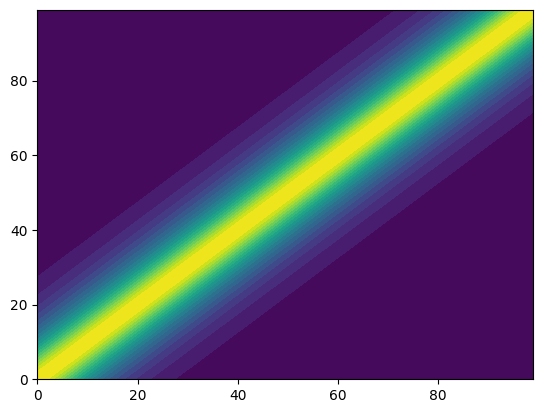

In [70]:
# Solution

def cov_func(t1: float, t2: float, l: float, σ: float) -> float:
    return (σ ** 2) * (1 + jnp.sqrt(3) * jnp.abs(t1 - t2) / l) * (jnp.exp(-jnp.sqrt(3) * jnp.abs(t1 - t2) / l))

vectorized_cov_func = jax.vmap(jax.vmap(cov_func, in_axes=(0, None, None, None)), in_axes=(None, 0, None, None))

# Equivalently,
# @partial(jax.vmap, in_axes=(None, 0, None, None))
# @partial(jax.vmap, in_axes=(0, None, 0, 0))
# def cov_func(t1: float, t2: float, l: float, σ: float) -> float:
#     return (σ ** 2) * (1 + jnp.sqrt(3) * jnp.abs(t1 - t2) / l) * (jnp.exp(-jnp.sqrt(3) * jnp.abs(t1 - t2) / l))

ts = jnp.linspace(0.01, 1, 100)

l, σ = 0.1, 1.
cov_matrix = vectorized_cov_func(ts, ts, l, σ)

plt.contourf(cov_matrix, levels=20)

Now we compare the speed of NumPy-style and JAX-style code.

In [61]:
# NumPy implementation 1. Naive implementation with two loops. Do not use this in practice.

def np_cov_func(t1, t2):
    cov_matrix = np.zeros((ts.size, ts.size))
    for i, t1 in enumerate(ts):
        for j, t2 in enumerate(ts):
            z = np.sqrt(3) * np.abs(t1 - t2) / l
            cov_matrix[i, j] = σ**2 * (1 + z) * np.exp(-z)
    return cov_matrix

ts_np = np.asarray(ts)
%timeit np_cov_func(ts_np, ts_np)

79 ms ± 6.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [62]:
# NumPy implementation 2. Using broadcasting.
# While useful, this is applicable only for limited applications.

def np_cov_func(t1, t2):
    z = np.sqrt(3) * np.abs(t1[:, None] - t2[None, :]) / l
    return σ ** 2 * (1 + z) * np.exp(-z)

ts_np = np.asarray(ts)
%timeit np_cov_func(ts_np, ts_np)

45.8 μs ± 1.2 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [63]:
# NumPy implementation 3. Using SciPy `cdist`.

import scipy.spatial

def np_cov_func(t1, t2):
    r = scipy.spatial.distance.cdist(t1, t2, 'euclidean')
    z = np.sqrt(3) * r / l
    return σ ** 2 * (1 + z) * np.exp(-z)

ts_np = np.asarray(ts).reshape(-1, 1)
%timeit np_cov_func(ts_np, ts_np)

41.9 μs ± 1.65 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [76]:
%timeit vectorized_cov_func(ts, ts, l, σ).block_until_ready()

1.79 ms ± 73.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [77]:
# In principle, we should not jit vmap which is jitted already, 
# but for some reasons the jitted vmap is faster than that of non-jitted in my computer.
f = jax.jit(vectorized_cov_func)
_ = f(ts, ts, l, σ)

%timeit f(ts, ts, l, σ).block_until_ready()

36.3 μs ± 503 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


There is also `jax.pmap`. This is for parallelization across different divices, for example, multiple GPUs/TPUs. See details [here](https://docs.jax.dev/en/latest/sharded-computation.html). 

## Auto-Differentiation

### Gradient

Consider a function $f: \mathbb R^d \rightarrow \mathbb R$. JAX computes the gradient of $f$ by `grad_f = jax.grad(f)`.

We will practice by implementing examples. Let a function $f$ be defined as $$f(x) = x^\top A x.$$ Compute $\nabla f$, and compare with the true gradient $2 A x$.

In [80]:
A = jnp.eye(2)

def f(x):
    return jnp.dot(x, A @ x)

grad_f = jax.grad(f)
grad_f(jnp.array([1., 2.]))

Array([2., 4.], dtype=float64)

Next, consider an MLE objective function $$\ell(\theta) = x^\top A^{-1}(\theta)x,$$ where $$A(\theta) = \begin{bmatrix} 2 & \text{sigmoid}(\theta) \\ \text{sigmoid}(\theta) & 3 \end{bmatrix},$$ and $x \in \mathbb R^2$ is given. Compute $\nabla \ell$ at $\theta = 2$, and compare the result to that of the finite difference.

In [86]:
import jax.scipy

key = jax.random.PRNGKey(100)
x = jax.random.normal(key, shape=(2, ))

def sigmoid(θ):
    return 1 / (1 + jnp.exp(-θ))

def mle_objective(θ):
    A = jnp.array([[2., sigmoid(θ)], 
                   [sigmoid(θ), 3.]])
    chol = jax.scipy.linalg.cho_factor(A, lower=True)
    return jnp.dot(x, jax.scipy.linalg.cho_solve(chol, x))

grad_mle_obj = jax.grad(mle_objective)
print('[01] JAX auto-diff:', grad_mle_obj(2.))

# Compute gradient at 2. using finite difference.
print('[02] Finite diff  :', (mle_objective(2. + 1e-5) - mle_objective(2.)) / 1e-5)

[01] JAX auto-diff: 0.02155437443121922
[02] Finite diff  : 0.021554311946392343


### Jacobian and Hessian

JAX computes Jacobian of any function $f: \mathbb R^n \rightarrow \mathbb R^m$ by `jax.jacfwd` or `jax.jacrev`. They give the same results but are implemented in different ways:
- `jax.jacfwd` uses forward-mode autodiff, while
- `jax.jacrev` uses reverse-mode autodiff.

I am no expert in autodiff, but essentially, we use `jacfwd` when $n \ll m$ while we use `jacrev` when $n \gg m$ for the best computation speed. To obtain the Hessian of a function, we could use either `jacfwd(jacrev(f))` or `jax.hessian(f)`.

For example, take the Jacobian of $\nabla f$ from the first example, where $$f(x) = x^\top A x.$$

In [87]:
jac_of_gradf = jax.jacfwd(grad_f)

# Evaluate at x = (0.1, 0.2)
jac_of_gradf(jnp.array((0.1, 0.2)))

Array([[2., 0.],
       [0., 2.]], dtype=float64)

Next, consider a simple perceptron $$\text{NN}(x) = \text{sigmoid}(w^\top x + b).$$ Compute its gradient and Hessian with respect to the weight $w$. (*Hint.* Use a parameter `argnums` to specify positional argument(s) to differentiate with respect to.)

In [90]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def nn(x, weights, b):
    return sigmoid(jnp.dot(weights, x) + b)

key = jax.random.PRNGKey(100)
ws = jax.random.normal(key, shape=(10, ))

key, _ = jax.random.split(key)
xs = jax.random.normal(key, shape=(10, ))

grad_of_nn = jax.grad(nn, argnums=(1))
hessian_of_nn = jax.hessian(nn, argnums=(1))

print(grad_of_nn(xs, ws, 1.))
print(hessian_of_nn(xs, ws, 1.))

[ 1.91972490e-01 -1.03381322e-01 -2.31600852e-02 -8.93785534e-02
 -3.23622463e-01 -3.45593031e-01  2.09718645e-01  1.25725821e-05
  1.58379847e-01 -1.47384540e-01]
[[-7.72030384e-02  4.15754998e-02  9.31398529e-03  3.59441913e-02
   1.30146968e-01  1.38982581e-01 -8.43397750e-02 -5.05614916e-06
  -6.36935292e-02  5.92716921e-02]
 [ 4.15754998e-02 -2.23893026e-02 -5.01578179e-03 -1.93567216e-02
  -7.00869466e-02 -7.48451147e-02  4.54187863e-02  2.72284528e-06
   3.43003380e-02 -3.19190834e-02]
 [ 9.31398529e-03 -5.01578179e-03 -1.12366461e-03 -4.33640535e-03
  -1.57012854e-02 -1.67672379e-02  1.01749807e-02  6.09987637e-07
   7.68416123e-03 -7.15069873e-03]
 [ 3.59441913e-02 -1.93567216e-02 -4.33640535e-03 -1.67348969e-02
  -6.05938263e-02 -6.47075112e-02  3.92669132e-02  2.35404197e-06
   2.96544339e-02 -2.75957149e-02]
 [ 1.30146968e-01 -7.00869466e-02 -1.57012854e-02 -6.05938263e-02
  -2.19398531e-01 -2.34293389e-01  1.42177901e-01  8.52353088e-06
   1.07372972e-01 -9.99187488e-02]
 

### Jacobian-Vector Product (JVP), Vector-Jacobian Product (VJP), and Hessian Vector Product (HVP)

In a plethora of applications, it is not the Jacobian or Hessian you want to solve, but the matrix-vector product $\text Jx$ for some Jacobian or Hessian $\text J$ and a vector $x$. For example, a commonly seen operator in SDE or PDE is $$(A\phi)(x) = \nabla_x\phi \cdot a(x) + \frac{1}{2}\text{tr}\left( \Gamma(x) \text H_x\phi \right),$$ and other examples include Gauss-Newton, quasi-Newton methods, and extended Kalman filters, etc. These can be solved efficiently using `jax.vjp` and `jax.jvp`. For details, see [here](https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html#how-it-s-made-two-foundational-autodiff-functions).

## Control Flows

Does this work?

In [92]:
def test_if(x):
    if x < 0:
        return -x
    else:
        return x

test_if(jnp.array(-1.))

Array(1., dtype=float64, weak_type=True)

Yes, it works. How about the for loop?

In [93]:
def test_for(x):
    for i in range(5):
        x = jnp.eye(2) @ x
    return x

test_for(jnp.ones((2, )))

Array([1., 1.], dtype=float64)

Yes, it works too! It *seems* a fuss to worry about using normal Python control flows. But, if we want to use `jit` or some autodiff features, you need to be careful with control flows.

For instance, will this work?

In [94]:
@jax.jit
def test_if(x):
    if x < 0:
        return -x
    else:
        return x
    
test_if(jnp.array(-1.))

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function test_if at /var/folders/n5/bkphn15s0kzc1lsr8x64v8y00000gn/T/ipykernel_1159/330552377.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

No, the error message explained it well already. Basically, it fails because we are building a computational graph that changes based on the **concrete** calue of a variable. We can force this example to work by using `static_argnums` argument for `jit`. But please use it only if this is intentional, that is, `x` is really static.

Recall that `jax.jit` needs to trace all the (numerical) operations to compile to XLA code. `jax.jit` cannot trace the Python control flows, such as `if else` and `for`. If the function to be jitted has a for loop, then the operations in the for loop are hardcoded to the XLA program. Why? Imagine we ask you to implement a function
```python
def my_jit(f):
    return ...
```
such that `my_jit` takes a function `f` as input and detect whether the function has a for loop. This is super difficult, and we might need to print the function `f` as string then semantically search for the `for`.

The following is a more illustrative example. Suppose that JAX can compile a Python code to a C code. How would the compiled C code of
```python
for i in range(100):
    x = f(x)
``` 
look like? We expect to get a C code like this:
```c
for (int i = 0; i < 100; i++) {
    x = f(x);
}
```
But actually, we get
```c
x = f(x);
x = f(x);
... // hardcore-repeat 100 times
```
Hence, if we desire `for` or `if` in the runtime, we need to write something that `jax` could understand and parse, that are, JAX primitives.

### Conditional Statements and Blocks

Consider a Python *if-else* statement.
```python
if condition:
    result = true_func(x)
else:
    result = false_func(x)
```
In JAX, we write as
```python
result = jax.lax.cond(condition, true_func, false_func, operand=x)
```
Let us implement `test_if` in JAX as an example.

In [95]:
@jax.jit
def test_if(x):
    return jax.lax.cond(x < 0.,       # condition
                        lambda _: -x, # what to execute if the condition is true
                        lambda _: x,  # what to execute if the condition is false
                        x)            # operand here can be anything because we used x from outer scope


test_if(jnp.array(-1.))

Array(1., dtype=float64, weak_type=True)

In [96]:
@jax.jit
def test_if(x):
    return jax.lax.cond(x < 0.,
                        lambda u: -u,
                        lambda u: u, 
                        x)

test_if(jnp.array(-1.))

Array(1., dtype=float64, weak_type=True)

Let's try some simple exercise. Write ELU activation function in JAX and JIT it.

$$\text{elu}(x) = \begin{cases} e^x, & x < 0\\ 1, &x \ge 0\end{cases}$$

In [98]:
@jax.jit
def elu(x):
    return jax.lax.cond(x < 0.,
                        lambda _: jnp.exp(x),
                        lambda _: 1.,
                        x)

# Test
elu(1.)

Array(1., dtype=float64, weak_type=True)

What if we have multiple if conditions, i.e., `if elif elif ... else`? Then use `jax.switch`. What if we have vector input? Then use `jnp.where` or `jax.vmap`.

### Loops

|construct|jit|grad|
|----|----|----|
|`if`|❌|✅|
|`for`|✅*|✅|
|`while`|✅*|✅|
|`lax.cond`|✅|✅|
|`lax.while_loop`|✅|fwd|
|`lax.fori_loop`|✅|fwd|
|`lax.scan`|✅|✅|

\* means argument-valuable-independent loop condition - unrolls the loop. See [here](https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html)

Similar to the `jax.lax.cond` we have seen above, for loops, we have `jax.lax.while_loop`, `jax.lax.fori_loop`, `scan`. Consider a naive numpy implementation of summation:

```python
def my_sum(x):
    summation = 0.
    for i in range(x.shape[0]):
        summation += x[i]
    return summation
```

The JAX implementation of it is

In [99]:
def my_sum(x):

    def body_func(i, val):
        return x[i] + val
    
    return jax.lax.fori_loop(lower=0,            # the starting index
                             upper=x.shape[0],   # the number of loops
                             body_fun=body_func, # the loop body (index, previous_val) -> val
                             init_val=0.)        # initial value of the loop val

my_sum(jnp.ones((10, )))

Array(10., dtype=float64)

The compiled function looks like this:

In [100]:
jax.make_jaxpr(my_sum)(jnp.ones((10, )))

{ lambda ; a:f64[10]. let
    _:i64[] b:f64[] = scan[
      _split_transpose=False
      jaxpr={ lambda ; c:f64[10] d:i64[] e:f64[]. let
          f:i64[] = add d 1
          g:bool[] = lt d 0
          h:i64[] = convert_element_type[new_dtype=int64 weak_type=False] d
          i:i64[] = add h 10
          j:i64[] = select_n g d i
          k:f64[1] = dynamic_slice[slice_sizes=(1,)] c j
          l:f64[] = squeeze[dimensions=(0,)] k
          m:f64[] = convert_element_type[new_dtype=float64 weak_type=False] e
          n:f64[] = add l m
        in (f, n) }
      length=10
      linear=(False, False, False)
      num_carry=2
      num_consts=1
      reverse=False
      unroll=1
    ] a 0 0.0
  in (b,) }

Now that if we don't use the JAX language `jax.fori_loop` but simply use Python for loop, what does JAX see?

In [102]:
# This loop is jittable indeed, but ...
def my_sum_native(x):
    summation = 0.
    for i in range(x.shape[0]):
        summation += x[i]
    return summation

jax.make_jaxpr(my_sum_native)(jnp.ones(10, ))

{ lambda ; a:f64[10]. let
    b:f64[1] = slice[limit_indices=(1,) start_indices=(0,) strides=None] a
    c:f64[] = squeeze[dimensions=(0,)] b
    d:f64[] = add 0.0 c
    e:f64[1] = slice[limit_indices=(2,) start_indices=(1,) strides=None] a
    f:f64[] = squeeze[dimensions=(0,)] e
    g:f64[] = add d f
    h:f64[1] = slice[limit_indices=(3,) start_indices=(2,) strides=None] a
    i:f64[] = squeeze[dimensions=(0,)] h
    j:f64[] = add g i
    k:f64[1] = slice[limit_indices=(4,) start_indices=(3,) strides=None] a
    l:f64[] = squeeze[dimensions=(0,)] k
    m:f64[] = add j l
    n:f64[1] = slice[limit_indices=(5,) start_indices=(4,) strides=None] a
    o:f64[] = squeeze[dimensions=(0,)] n
    p:f64[] = add m o
    q:f64[1] = slice[limit_indices=(6,) start_indices=(5,) strides=None] a
    r:f64[] = squeeze[dimensions=(0,)] q
    s:f64[] = add p r
    t:f64[1] = slice[limit_indices=(7,) start_indices=(6,) strides=None] a
    u:f64[] = squeeze[dimensions=(0,)] t
    v:f64[] = add s u
    w:

See? Again recall that JAX cannot trace the Python control flows.

Now we practice with some examples. Consider a recursion $$X_t = 0.1 X_{t-1} + U_t, \quad \forall t = 1, \cdots, T.$$ Suppose that the initial $X_0$ and inputs $\{U_t\}^{T}_{t=1}$ are known. Compute $X_T$.

In [103]:
# Simple NumPy way of implementation
def recursion(x0, us):
    T = us.shape[0]
    x = x0
    for t in range(T):
        x = 0.1 * x + us[t]
    return x

recursion(np.array(0.1), 0.2 * np.ones((10, )))

np.float64(0.22222222221000001)

In [106]:
# JAX way of implementation
def recursion(x0, us):

    def body_func(t, x):
        x = 0.1 * x + us[t]
        return x

    return jax.lax.fori_loop(lower=0,
                             upper=us.shape[0],
                             body_fun=body_func,
                             init_val=x0)

recursion(jnp.array(0.1), 0.2 * jnp.ones((10, )))

Array(0.22222222, dtype=float64)

Wait a sec, but the function only returns the value of $X$ at $T$. How do I keep all the history results? This is very simple in NumPy. Just introduce a result accumulator, say, `xs`.

In [107]:
def recursion(x0, us):
    T = us.shape[0]
    xs = np.zeros((T, )) # the accumulator

    x = x0
    for t in range(T):
        x = 0.1 * x + us[t]
        xs[t] = x
    return xs

recursion(np.array(0.1), 0.2 * np.ones((10, )))

array([0.21      , 0.221     , 0.2221    , 0.22221   , 0.222221  ,
       0.2222221 , 0.22222221, 0.22222222, 0.22222222, 0.22222222])

Can I do the same in JAX?

In [108]:
@jax.jit
def recursion(x0, us):
    xs = jnp.zeros((T, ))

    def fori_body(t, x):
        x = 0.1 * x + us[t]
        xs[t] = x
        return x
    
    return jax.lax.fori_loop(lower=0,
                             upper=us.shape[0],
                             body_fun=fori_body,
                             init_val=x0)

No. We will get an error in the line `xs[t] = x` because JAX DeviceArray are immutable (i.e., no assignment). We can, to some extent, force `xs[k] = x` to work by using "JAX array update" at the cost of making your program nasty, slow, and unreadable. The authentic way to do it is by using the `scan` operation, because $$X_{t} = 0.1 X_{t-1} + U_{t}$$ is essentially a scan operation. Think about what the essential parts of such scan loop are, then we can abstract them.

In [109]:
def recursion(x0, us):

    def scan_body(carry, elem):
        # Unpack carry and elem
        x = carry
        u = elem

        x = 0.1 * x + u
        return x, x # scan body returns two values. First returns as the next carry, the second goes to the result container.
    
    return jax.lax.scan(scan_body, # the scan body function
                        x0,        # initial value/carry
                        us)        # inputs

last_x, xs = recursion(jnp.array(0.1), 0.2 * jnp.ones((10, )))

In [110]:
xs

Array([0.21      , 0.221     , 0.2221    , 0.22221   , 0.222221  ,
       0.2222221 , 0.22222221, 0.22222222, 0.22222222, 0.22222222],      dtype=float64)

Here is the last exercise. Consider a stochastic differential equation $$dX(t) = \sin(10 \pi X(t))dt + dW(t)$$ where $X(0) = 0.1$. Use Euler-Maruyama to simulate a trajectory of $X$ at times $0.01, 0.02, \cdots, 1$. The formula is $$X(t_k) \approx X(t_{k-1}) + \sin(10 \pi X(t_{k-1}))(t_k - t_{k-1}) + \Delta W_k, \quad \Delta W_k \sim N(0, t_k - t_{k-1}).$$

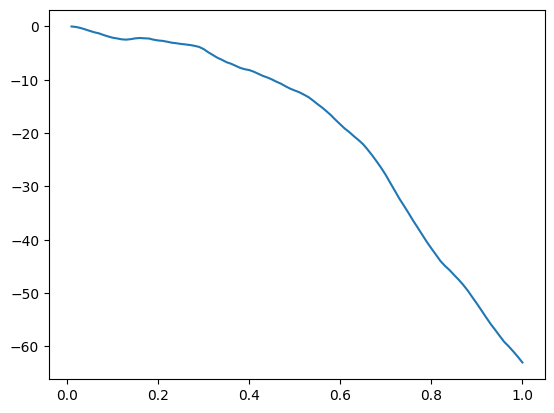

In [112]:
dt = 0.01
T = 100
ts = jnp.linspace(dt, dt * T, T)

key = jax.random.PRNGKey(100)
ws = jnp.cumsum(jnp.sqrt(dt) * jax.random.normal(key, (T, ))) # Wiener process at times

def scan_body(carry, elem):
    x = carry
    dw = elem

    x = x + jnp.sin(10 * jnp.pi * x) * dt + dw
    return x, x

_, xs = jax.lax.scan(scan_body, jnp.array(0.1), ws)
plt.plot(ts, xs)

## References

- **Sargent, Thomas J. and John Stachurski. n.d.** "Quantitative Economics with Python using JAX." QuantEcon. https://jax.quantecon.org/intro.html
- **Zhao, Zheng. 2022.** "JAX Workshop." A Computational Introduction to Stochastic Differential Equations. https://github.com/spdes/computational-sde-intro-lecture/tree/main/lectures/seminar_lectures/zhao_jax_workshop